In [5]:
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.utils import resample

## Error functions

In [6]:
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# Exercise 1: OLS on the Franke function
- Mathematical interpretation of OLS: OLS is a projection of the original target vector, y, onto your prediction, $\tilde{y}$, by a matrix $\beta$, which is defined by the coulumn vectors of your matrix X.

## Notes on scaling:
- In this Franke function, x and y is already scaled between 0 and 1
- The function does not vary very much (without noise)
- Recomendation from Morten: Do it yourself. Take design matrix and subtract the mean values, before or after train-test-split
- Scale y as well, y -> y - mean(y), $\beta_0$ = mean(y)

## Results 
- As expected, scaling does not make any significant difference on the mse and $r^2$
- MSE error with noise (mean=0, sigma=1) and N=1000 shrinks from 1.025 to 1 for both test and train
- MSE error without noise and N=1000 shrinks from 0.0225 to 0.0025 for both test and train
- Using low N (~10) can give increased test error, but becomes random each time

## Make Franke function and plot

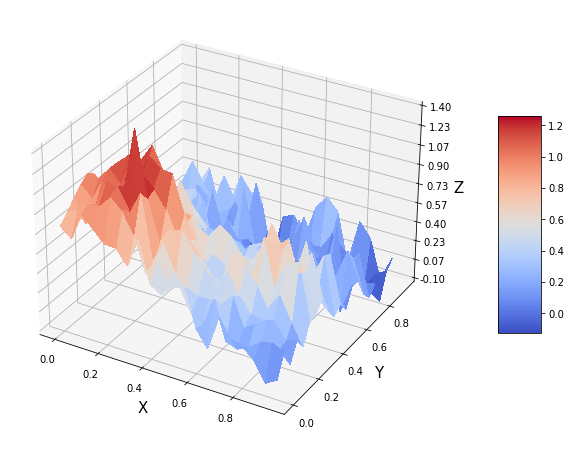

In [267]:
fig = plt.figure(figsize=(20,8))
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    noise = np.random.normal(0,0.15,x.shape)
    return term1 + term2 + term3 + term4 + noise


z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set_xlabel('X', fontsize=15)
ax.set_ylabel('Y', fontsize=15)
ax.set_zlabel('Z', fontsize=15)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Make design matrix with polynomial degree n

In [8]:
def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of columns in beta
    X = np.ones((N,l)) # matrix with N rows, l columns

    for i in range(1,n+1):
        q = int((i)*(i+1)/2) 
        for k in range(i+1): 
            X[:,q+k] = (x**(i-k))*(y**k)

    return X

## OLS regression with polynomial degree 1-5

In [270]:
# Making meshgrid of datapoints and compute Franke's function
n = 5
N = 20
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)

z = FrankeFunction(x_flat, y_flat)
#z = z - np.mean(z)

polydegree = np.zeros(n)
r2_train = np.zeros(n)
r2_test = np.zeros(n)
mse_train = np.zeros(n)
mse_test = np.zeros(n)

# OLS regression for polynomials from 1 to n
for i in range(n):
    n = i+1
    print(n)
    polydegree[i] = n
    X = create_X(x_flat, y_flat, n)
    #X = X - np.mean(X)
    X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
    
    # prediction
    betaOLS = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
    ztilde_train = X_train @ betaOLS
    ztilde_test = X_test @ betaOLS
    
    # errors
    r2_train[i] = r2_score(z_train, ztilde_train)
    r2_test[i] = r2_score(z_test, ztilde_test)
    mse_train[i] = mean_squared_error(z_train, ztilde_train) #MSE(z_train,ztilde_ols_train)
    mse_test[i] = mean_squared_error(z_test, ztilde_test)  #MSE(z_test,ztilde_ols_test)

1
2
3
4
5


## Plot error as function of complexity

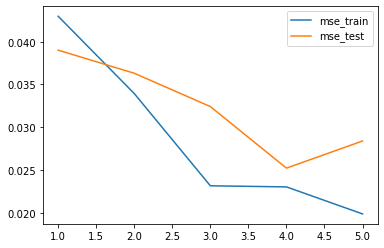

In [271]:
plt.plot(polydegree, mse_train, label='mse_train')
plt.plot(polydegree, mse_test, label='mse_test')
#plt.plot(polydegree, r2_train, label='r2_train')
#plt.plot(polydegree, r2_test, label='r2_test')
plt.legend()
plt.show()

## Make confidence intervals
- $\mu_{\beta} \pm \frac{2\sigma_{\beta}}{\sqrt{n}}$

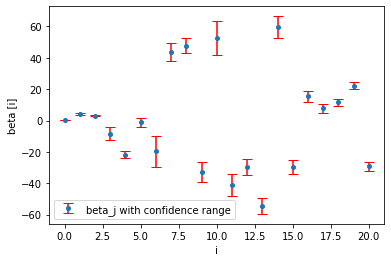

,Beta,+-
0,0.555488,0.058823
1,4.103633,0.775424
2,3.122444,0.547996
3,-8.354188,4.050991
4,-21.805718,2.307614
5,-1.243826,2.664445
6,-19.661471,9.755445
7,43.740228,5.614364
8,47.742183,4.701250
9,-32.735881,6.185533


In [272]:
variance = np.zeros(len(betaOLS))
CI = np.zeros(len(betaOLS))

for i in range(len(betaOLS)):
    variance[i] = 0.1**2 * np.linalg.pinv(X_train.T @ X_train)[i,i]
    CI[i] = 2*np.sqrt(variance[i])/np.sqrt(N)

plt.errorbar(np.arange(0,len(betaOLS)), betaOLS, yerr=CI, fmt='o', ecolor='red', capsize=5, markersize=4, label='beta_j with confidence range')
plt.xlabel('i')
plt.ylabel('beta [i]')
plt.legend()
plt.show()

table = pd.DataFrame({'Beta': betaOLS, '+-': CI})
table

# Exercise 2 - Bias-variance trade-off and resampling techniques

## Notes
- scaling or not scaling - no difference as expected (ref notes exercise 1)
- Increasing from 50 bootstraps gives no improved results
- Increasing N from 100 only smoothens the curve
- Polynomial degree above 10 does not decrease errors

## OLS regression with bootstrap 

1.0325752003949362
0.467865093189798
0.4125396862920006
0.347535412020692
0.32593296100269425
0.3581780322806616
0.417489979978341
0.7634757514978708
2.093737773012761


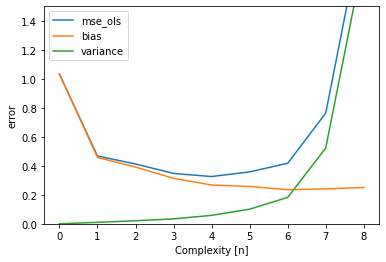

In [228]:
N = 100
n_bootstraps = 1000
maxdegree = 9
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)

polydegree = np.zeros(maxdegree)
mse_error = np.zeros(maxdegree)
r2_error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
mse_est = np.zeros(maxdegree)

z = FrankeFunction(x_flat, y_flat)
#z = z - np.mean(z)
scaler = StandardScaler()
for i in range(maxdegree):
    degree = i
    polydegree[i] = degree
    X = create_X(x_flat, y_flat, degree)

    X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
    scaler_x = scaler.fit(X_train)
    X_train = scaler_x.transform(X_train)
    X_test = scaler_x.transform(X_test)
    
    scaler_z = scaler.fit(z_train.reshape(-1,1))
    z_train = scaler_z.transform(z_train.reshape(-1,1)).ravel()
    z_test = scaler.transform(z_test.reshape(-1,1)).ravel()
    

    z_pred = np.empty((z_test.shape[0], n_bootstraps))
    for j in range(n_bootstraps):
        x_bs,z_bs = resample(X_train, z_train, n_samples=100)
        beta_ols = np.linalg.pinv(x_bs.T @ x_bs) @ x_bs.T @ z_bs
        z_pred[:,j] = X_test @ beta_ols
    
    mse_error[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred)**2, axis=1, keepdims=True))
    bias[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred, axis=1, keepdims=True))**2)
    variance[i] = np.mean(np.var(z_pred, axis=1, keepdims=True))
    print(mse_error[i])
    
plt.plot(polydegree, mse_error, label='mse_ols')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='variance')
plt.xlabel('Complexity [n]')
plt.ylabel('error')
plt.ylim(0,1.5)
plt.legend()
plt.show()

## Discussion on bias-variance trade-off

- Varier polynomgrad n, punkter N og antall bootstraps n_bootstraps og diskuter forskjellene


# Exercise 3 - cross validation as resampling technique, adding more complexity

In [173]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

N = 100
degree = 5
k = 10
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)
mse_scores = []

z = FrankeFunction(x_flat, y_flat)
#z = z - np.mean(z)
X = create_X(x_flat, y_flat, degree)
#X = X - np.mean(X)

kfold = KFold(n_splits = k, shuffle=True)

for train_indexes, test_indexes in kfold.split(X):
    #print(train_indexes)

    X_train = X[train_indexes]
    X_test = X[test_indexes]
    z_train = z[train_indexes]
    z_test = z[test_indexes]

    beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
    z_pred = X_test @ beta
    mse_scores.append(mean_squared_error(z_test, z_pred))

print(mse_scores)

print(np.mean(mse_scores))

[0.02568571967240019, 0.0238028671151898, 0.025057881669536316, 0.02411680253419607, 0.024140337700135076, 0.023813572833604035, 0.023450794457555057, 0.023216425429540864, 0.02631152551577467, 0.025307514928751128]
0.02449034418566832


## CV with scikit cross_val_score

In [174]:
linreg = LinearRegression()
mse_scikit_linreg = cross_val_score(linreg, X, z, scoring='neg_mean_squared_error', cv=kfold)


print(np.mean(mse_scikit_linreg))

-0.024464437844554574


# Exercise 4 - Ridge regression on the Franke function with resampling 

- Ridge: Shrinking beta-coefficients with large variance, but never to zero
- Lasso: Same, but can shrink to zero
- Noisy function means large variance
- To compare OLS/ridge/beta, try to compute coefficients and see with/without noise
- Beta coefficients in ridge are given by Gaussian distribution, in Lasso they are given by Laplace distribution (thats why they can go to zero)

- Scaling: Subtracting the mean value means first column of design matrix (1,1,1,...) becomes zero.

Degree: 0    lambda: 1.0000    mse_ridge: 1.0106    mse_ols: 1.0106
Degree: 1    lambda: 1.0000    mse_ridge: 0.4889    mse_ols: 0.4889
Degree: 2    lambda: 1.0000    mse_ridge: 0.4291    mse_ols: 0.4291
Degree: 3    lambda: 1.0000    mse_ridge: 0.2924    mse_ols: 0.3653
Degree: 4    lambda: 1.0000    mse_ridge: 0.2903    mse_ols: 0.3322
Degree: 5    lambda: 1.0000    mse_ridge: 0.2588    mse_ols: 0.3248
Degree: 6    lambda: 1.0000    mse_ridge: 0.2514    mse_ols: 0.3201
Degree: 7    lambda: 1.0000    mse_ridge: 0.2523    mse_ols: 0.3159
Degree: 8    lambda: 1.0000    mse_ridge: 0.2720    mse_ols: 0.3079
Degree: 9    lambda: 1.0000    mse_ridge: 0.3021    mse_ols: 0.3045


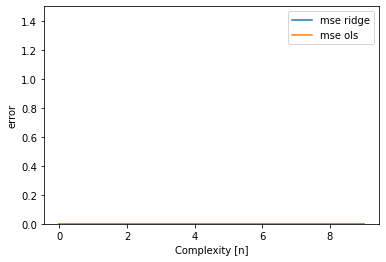

In [274]:
N = 20
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)

z = FrankeFunction(x_flat, y_flat) 

#Bootstrap parameters
n_bootstraps = 1000
maxdegree = 10

#cross_validation parameters
k = 10

polydegrees = np.zeros(maxdegree)

#Error arrays
mse_error_ridge_bootstrap = np.zeros(maxdegree)
mse_error_ols_bootstrap = np.zeros(maxdegree)

bias_ridge_bootstrap = np.zeros(maxdegree)
bias_ols_bootstrap = np.zeros(maxdegree)

variance_ridge_bootstrap = np.zeros(maxdegree)
variance_ols_bootstrap = np.zeros(maxdegree)

mse_error_ridge_cvd = np.zeros(maxdegree)
mse_error_ols_cvd = np.zeros(maxdegree)

for i in range(maxdegree):
    degree = i
    polydegrees[i] = degree
    X = create_X(x_flat, y_flat, degree)
    X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
    
    scaler_x = scaler.fit(X_train)
    X_train = scaler_x.transform(X_train)
    X_test = scaler_x.transform(X_test)
    
    scaler_z = scaler.fit(z_train.reshape(-1,1))
    z_train = scaler_z.transform(z_train.reshape(-1,1)).ravel()
    z_test = scaler.transform(z_test.reshape(-1,1)).ravel()
    
    z_pred_ridge_bootstrap = np.empty((z_test.shape[0], n_bootstraps))
    z_pred_ols_bootstrap = np.empty((z_test.shape[0], n_bootstraps))
    """
    for j in range(n_bootstraps):
        lmd = 1
        x_bs,z_bs = resample(X_train,z_train, n_samples=50)
        beta_ridge_bootstrap = np.linalg.pinv(x_bs.T @ x_bs + lmd*np.eye(x_bs.shape[1],x_bs.shape[1])) @ x_bs.T @ z_bs
        beta_ols_bootstrap = np.linalg.pinv(x_bs.T @ x_bs) @ x_bs.T @ z_bs
        z_pred_ridge_bootstrap[:,j] = X_test @ beta_ridge_bootstrap
        z_pred_ols_bootstrap[:,j] = X_test @ beta_ols_bootstrap
    
    #Bootstrap errors
    mse_error_ridge_bootstrap[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred_ridge_bootstrap)**2, axis=1, keepdims=True))
    mse_error_ols_bootstrap[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred_ols_bootstrap)**2, axis=1, keepdims=True))
    
    bias_ridge_bootstrap[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred_ridge_bootstrap, axis=1, keepdims=True))**2)
    bias_ols_bootstrap[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred_ols_bootstrap, axis=1, keepdims=True))**2)
    
    variance_ridge_bootstrap[i] = np.mean(np.var(z_pred_ridge_bootstrap, axis=1, keepdims=True))
    variance_ols_bootstrap[i] = np.mean(np.var(z_pred_ols_bootstrap, axis=1, keepdims=True))
    
    print('Degree: %i    lambda: %.4f    mse_ridge: %.4f    mse_ols: %.4f' %(degree, lmb, mse_error_ridge_bootstrap[i], mse_error_ols_bootstrap[i]))
    
    """
    cv_split = 0
    mse_scores_ols_cvd = np.zeros(k)
    mse_scores_ridge_cvd = np.zeros(k)
    
    kfold = KFold(n_splits = k, shuffle=True)
    for train_indexes, test_indexes in kfold.split(X):
        X_train = X[train_indexes]
        X_test = X[test_indexes]
        z_train = z[train_indexes]
        z_test = z[test_indexes]
        
        scaler_x = scaler.fit(X_train)
        X_train = scaler_x.transform(X_train)
        X_test = scaler_x.transform(X_test)
    
        scaler_z = scaler.fit(z_train.reshape(-1,1))
        z_train = scaler_z.transform(z_train.reshape(-1,1)).ravel()
        z_test = scaler.transform(z_test.reshape(-1,1)).ravel()
        
        lmd = 1
        I_ = np.eye(X_train.shape[1], X_train.shape[1])
        
        beta_ols_cvd = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
        beta_ridge_cvd = np.linalg.pinv(X_train.T @ X_train + lmd*I_) @ X_train.T @ z_train
        
        z_pred_ols_cvd = X_test @ beta_ols_cvd
        z_pred_ridge_cvd = X_test @ beta_ridge_cvd
        
        mse_scores_ols_cvd[cv_split] = mean_squared_error(z_test, z_pred_ols_cvd)
        mse_scores_ridge_cvd[cv_split] = mean_squared_error(z_test, z_pred_ridge_cvd)
        
        cv_split += 1
    
    # Cvd errors
    mse_error_ridge_cvd[i] = np.mean(mse_scores_ols_cvd)
    mse_error_ols_cvd[i] = np.mean(mse_scores_ridge_cvd)
    
    print('Degree: %i    lambda: %.4f    mse_ridge: %.4f    mse_ols: %.4f' %(degree, lmb, mse_error_ridge_cvd[i], mse_error_ols_cvd[i]))
    
plt.plot(polydegrees, mse_error_ridge_bootstrap, label='mse ridge')
plt.plot(polydegrees, mse_error_ols_bootstrap, label='mse ols')
#plt.plot(polydegrees, bias, label='bias')
#plt.plot(polydegrees, variance, label='variance')
plt.xlabel('Complexity [n]')
plt.ylabel('error')
plt.ylim(0,1.5)
plt.legend()
plt.show()

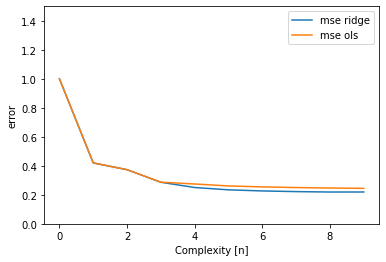

In [269]:
plt.plot(polydegrees, mse_error_ridge_cvd, label='mse ridge')
plt.plot(polydegrees, mse_error_ols_cvd, label='mse ols')
plt.xlabel('Complexity [n]')
plt.ylabel('error')
plt.ylim(0,1.5)
plt.legend()
plt.show()

In [182]:
N = 100
degree = 5
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)

z = FrankeFunction(x_flat, y_flat)
#z = z - np.mean(z)
X = create_X(x_flat, y_flat, degree)
#X = X - np.mean(X)
X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)


nlambdas = 100
lambdas = np.logspace(-5, 5, nlambdas)

# Cross-validation
k = 5
kfold = KFold(n_splits = k)
mse_ridge_cv = np.zeros(nlambdas)

# Bootstrap
n_bootstraps = 50
mse_ridge_bs = np.zeros(nlambdas)
bias_bs = np.zeros(nlambdas)
variance_bs = np.zeros(nlambdas)

for i in range(nlambdas):
    lmd = lambdas[i]
    # Cross validation
    mse_cv = []
    for train_indexes, test_indexes in kfold.split(X):
        X_train_cv = X[train_indexes]
        X_test_cv = X[test_indexes]
        z_train_cv = z[train_indexes]
        z_test_cv = z[test_indexes]

        beta_cv = np.linalg.pinv(X_train_cv.T @ X_train_cv + lmd*np.eye(X_train_cv.shape[1], X_train_cv.shape[1])) @ X_train_cv.T @ z_train_cv
        z_pred_cv = X_test_cv @ beta_cv
        mse_cv.append(mean_squared_error(z_test_cv, z_pred_cv))
    mse_ridge_cv[i] = np.mean(mse_cv)
    
    
    # Bootstrap
    z_pred = np.empty((z_test.shape[0], n_bootstraps))
    for j in range(n_bootstraps):
        x_bs,z_bs = resample(X_train, z_train)
        beta_bs = np.linalg.pinv(x_bs.T @ x_bs + lmd*np.eye(x_bs.shape[1], x_bs.shape[1])) @ x_bs.T @ z_bs
        z_pred_bs = X_test @ beta_bs
    
    mse_ridge_bs[i] = np.mean(np.mean((z_test.reshape(-1,1) - z_pred)**2, axis=1, keepdims=True))
    bias_bs[i] = np.mean((z_test.reshape(-1,1) - np.mean(z_pred, axis=1, keepdims=True))**2)
    variance_bs[i] = np.mean(np.var(z_pred, axis=1, keepdims=True))

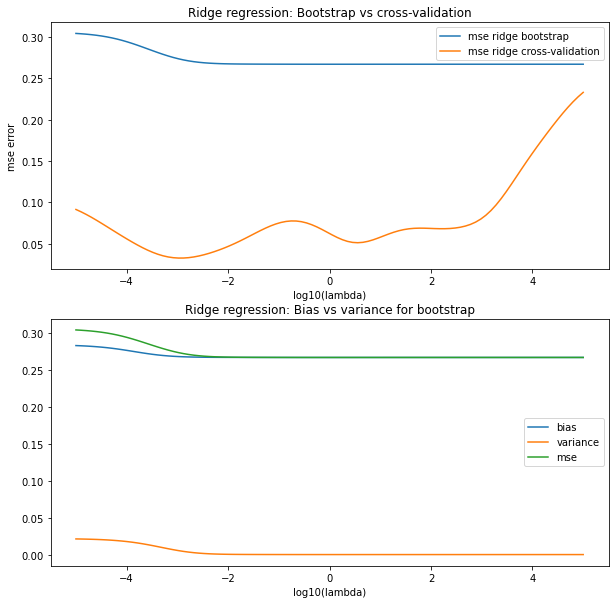

In [184]:
fig,ax = plt.subplots(2, figsize=(10,10))
ax[0].plot(np.log10(lambdas), mse_ridge_bs, label='mse ridge bootstrap')
ax[0].plot(np.log10(lambdas), mse_ridge_cv, label='mse ridge cross-validation')
ax[0].set_xlabel('log10(lambda)')
ax[0].set_ylabel('mse error')
ax[0].legend()
ax[0].set_title('Ridge regression: Bootstrap vs cross-validation')

ax[1].plot(np.log10(lambdas), bias_bs, label='bias')
ax[1].plot(np.log10(lambdas), variance_bs, label='variance')
ax[1].plot(np.log10(lambdas), mse_ridge_bs, label='mse')
ax[1].set_xlabel('log10(lambda)')
ax[1].legend()
ax[1].set_title('Ridge regression: Bias vs variance for bootstrap')
plt.show()

1e-05
[ 0.         -0.47190092 -1.04533796  0.0132746   0.10905637  0.02591823
 -0.02006025  0.06974872  0.02143452  0.04914172 -0.04078268  0.05117687
  0.00798072  0.00486246  0.04942074 -0.03334223  0.03906545  0.0060636
  0.          0.          0.04461692]
[ 0.00000000e+00 -6.06641631e-01 -7.03207873e-01  1.34556133e-02
  2.16507210e-01 -6.22553356e-02 -7.07878813e-02  1.85798285e-01
 -5.84461418e-03  0.00000000e+00 -8.87040614e-02  1.40265222e-01
 -1.99637358e-03 -1.42642106e-02  1.90598644e-02 -6.38615770e-02
  1.01939480e-01 -1.13235101e-03 -1.42063418e-02 -1.03740797e-04
  2.89285992e-02]
[ 0.00000000e+00 -7.04414977e-01 -6.93826573e-01  1.82911836e-03
  2.38290403e-01 -1.44301662e-01 -6.51441085e-02  2.57560938e-01
 -3.05586234e-02 -4.09437696e-02 -1.01773154e-01  1.94316611e-01
 -1.14026049e-02 -1.79409523e-02  2.31006719e-04 -7.65721081e-02
  1.28059491e-01 -1.27168220e-02 -1.63381956e-02  5.92421728e-04
  1.86337386e-02]
[ 0.         -0.62844693 -0.67330909  0.          0.

[ 0.         -0.62543034 -0.67136634 -0.          0.20061898 -0.1012782
 -0.06884907  0.21117787 -0.00792582 -0.03040624 -0.0883941   0.1486335
 -0.00201098 -0.00687313 -0.         -0.06121127  0.09197623 -0.00429995
 -0.01115546 -0.          0.00404477]
[ 0.00000000e+00 -7.05963121e-01 -7.01678701e-01 -0.00000000e+00
  2.59899459e-01 -2.31665126e-01 -5.68615655e-02  3.18838388e-01
 -5.56560838e-02 -9.68616871e-02 -1.09189591e-01  2.66964427e-01
 -4.00399352e-03 -8.35118381e-02 -8.31357764e-03 -9.32453498e-02
  1.98388204e-01 -0.00000000e+00 -5.20043076e-02 -4.88908468e-02
  2.54294550e-04]
1.873817422860383e-05
[ 0.00000000e+00 -4.64250583e-01 -1.02897784e+00  0.00000000e+00
  1.01042245e-01  1.34741961e-02 -8.34540943e-04  5.70422768e-02
  2.71092858e-02  4.95365797e-02 -3.46285987e-02  3.70744463e-02
  1.36555216e-02  7.49253598e-03  4.87619695e-02 -2.74449375e-02
  2.35567398e-02  1.18895236e-02  0.00000000e+00  8.58750788e-04
  4.47354483e-02]
[ 0.         -0.60227973 -0.69442357 

[ 0.         -0.61663513 -0.66557428 -0.          0.17773422 -0.09233109
 -0.05777851  0.19386468 -0.         -0.03003361 -0.08196893  0.13351272
 -0.         -0.         -0.         -0.05578077  0.07714227 -0.
 -0.         -0.          0.        ]
[ 0.00000000e+00 -6.98834773e-01 -6.96208916e-01 -0.00000000e+00
  2.19123479e-01 -2.13982707e-01 -3.73042076e-02  2.87774848e-01
 -1.35008477e-02 -1.10163864e-01 -1.05531914e-01  2.33789513e-01
 -0.00000000e+00 -4.57813811e-02 -2.15726406e-02 -8.49107197e-02
  1.64785808e-01 -0.00000000e+00 -9.98713870e-05 -5.89212716e-02
 -0.00000000e+00]
3.511191734215127e-05
[ 0.         -0.45043447 -0.99836781 -0.          0.06177454  0.
  0.          0.06240108  0.03376228  0.04451818 -0.01703658  0.01041328
  0.02476218  0.01340853  0.04704891 -0.01681547  0.          0.01630248
  0.0010775   0.00891102  0.04236443]
[ 0.         -0.58640274 -0.67691636 -0.          0.18153374 -0.04701715
 -0.03716205  0.14948245  0.          0.         -0.06814946  0.

[ 0.         -0.61713115 -0.66267586 -0.          0.12783001 -0.08701245
 -0.0262696   0.16531565  0.         -0.03747745 -0.07269664  0.12540439
  0.          0.         -0.00472662 -0.0560258   0.07572785  0.
  0.          0.         -0.        ]
[ 0.         -0.59588105 -0.65132538 -0.          0.1320411  -0.07451305
 -0.03719966  0.16073022  0.         -0.02245132 -0.06494384  0.10914279
  0.          0.         -0.         -0.04325277  0.0609967   0.
  0.          0.         -0.        ]
[ 0.         -0.67770928 -0.68109534 -0.          0.14259729 -0.18153305
 -0.00317352  0.23405802 -0.         -0.1021872  -0.08319302  0.19171167
  0.         -0.         -0.03674454 -0.0734117   0.12352534  0.
 -0.         -0.         -0.        ]
7.054802310718646e-05
[ 0.         -0.39583038 -0.87973196 -0.          0.          0.
 -0.          0.03254345  0.0268093   0.01081192 -0.          0.
  0.03055478  0.0186546   0.02647375 -0.          0.          0.
  0.00336787  0.01583851  0.02677828

[ 0.         -0.57471876 -0.63807091 -0.          0.04312813 -0.0522488
 -0.          0.11678748  0.         -0.02522129 -0.02851761  0.07314448
  0.          0.         -0.         -0.0261212   0.03813756  0.0013147
  0.          0.         -0.        ]
[ 0.         -0.55514196 -0.62004919 -0.          0.03986422 -0.03821071
 -0.          0.09759272  0.         -0.0078816  -0.02826771  0.05820283
  0.          0.         -0.         -0.01705705  0.0273241   0.
  0.          0.         -0.        ]
[ 0.         -0.58282772 -0.67117526 -0.          0.02974778 -0.09955269
 -0.          0.15679617  0.         -0.07564454 -0.02832361  0.1036449
  0.          0.         -0.02204174 -0.0371733   0.06453249  0.
  0.          0.         -0.        ]
0.00014174741629268049
[ 0.         -0.34611962 -0.80643482 -0.         -0.         -0.
 -0.          0.          0.          0.         -0.          0.
  0.          0.          0.         -0.          0.          0.
  0.01846418  0.0205472   0.01

[ 0.         -0.47260369 -0.56057322 -0.          0.         -0.02114579
 -0.          0.          0.         -0.         -0.          0.
  0.          0.         -0.         -0.          0.          0.
  0.          0.         -0.        ]
[ 0.         -0.47858732 -0.61597221 -0.          0.         -0.08754743
 -0.          0.          0.         -0.02029211 -0.          0.
  0.          0.         -0.         -0.          0.          0.
  0.          0.         -0.        ]
0.0002848035868435802
[ 0.         -0.29214985 -0.73465627 -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.
  0.          0.          0.        ]
[ 0.         -0.37469281 -0.51501745 -0.         -0.         -0.
 -0.          0.          0.         -0.         -0.          0.
  0.          0.         -0.         -0.          0.          0.
  0.          0.         -0.        ]
[ 0.         -0.46853679 -0.57

0.0005336699231206312
[ 0.         -0.2135586  -0.64436102 -0.         -0.00139097 -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.        ]
[ 0.         -0.29658544 -0.44709462 -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.        ]
[ 0.         -0.39042942 -0.51733091 -0.         -0.         -0.03200705
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.        ]
[ 0.         -0.38847199 -0.48937237 -0.         -0.         -0.01721418
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.        ]
[ 0.         -0.39428855 -0.53

[ 0.         -0.26326566 -0.38340999 -0.         -0.         -0.01136307
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.        ]
[ 0.         -0.26908222 -0.41851488 -0.         -0.         -0.07689697
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.        ]
0.001
[ 0.         -0.         -0.42809718 -0.         -0.14924862 -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.        ]
[ 0.         -0.1502265  -0.31981964 -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.        ]
[ 0.         -0.24407048 -0.40127748 -0.      

[ 0.         -0.         -0.         -0.         -0.11031452 -0.1892183
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.        ]
0.001873817422860385
[ 0.         -0.         -0.16022486 -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.        ]
[ 0.         -0.         -0.08132957 -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.        ]
[ 0.         -0.         -0.18254493 -0.         -0.03893742 -0.00573699
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.        ]
[ 0.         -0.         -0.1102

[ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0.]
[ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0.]
[ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0.]
[ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0.]
0.006135907273413176
[ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0.]
[ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0.]
[ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0.]
[ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0.]
[ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0.]
0.006579332246575682
[ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0.]
[ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0.]
[

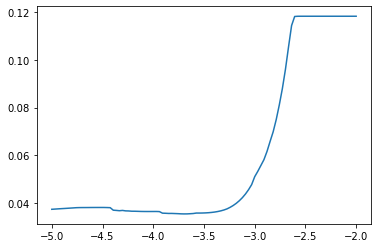

In [118]:
from sklearn.linear_model import Lasso

N = 100
degree = 5
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)


z = FrankeFunction(x_flat, y_flat)
#z = z - np.mean(z)
X = create_X(x_flat, y_flat, degree)
#X = X - np.mean(X)


nlambdas = 100
lambdas = np.logspace(-5, -2, nlambdas)
k = 5
kfold = KFold(n_splits = k)

mse_lasso_bs = np.zeros(nlambdas)
mse_lasso_cv = np.zeros(nlambdas)
bias = np.zeros(nlambdas)
variance = np.zeros(nlambdas)

for i in range(nlambdas):
    lmd = lambdas[i]
    print(lmd)
    # Cross validation
    mse_cv = []
    mse_bs = []
    lassoreg = Lasso(alpha=lmd, normalize = True, tol = 0.1)
    for train_indexes, test_indexes in kfold.split(X):
        X_train_cv = X[train_indexes]
        X_test_cv = X[test_indexes]
        z_train_cv = z[train_indexes]
        z_test_cv = z[test_indexes]

        lassoreg.fit(X_train_cv, z_train_cv)
        z_pred_cv = lassoreg.predict(X_test_cv)
        print(lassoreg.coef_)
        
        mse_cv.append(mean_squared_error(z_test_cv, z_pred_cv))
    mse_lasso_cv[i] = np.mean(mse_cv)
        
plt.plot(np.log10(lambdas), mse_lasso_cv)
plt.show()

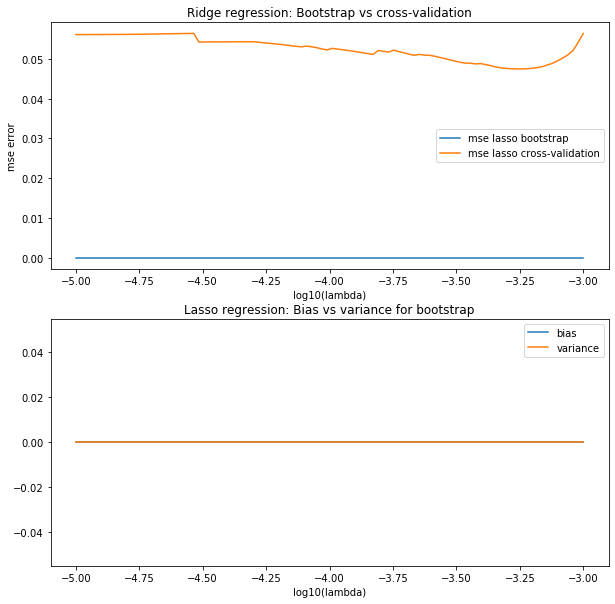

In [20]:
fig,ax = plt.subplots(2, figsize=(10,10))
ax[0].plot(np.log10(lambdas), mse_lasso_bs, label='mse lasso bootstrap')
ax[0].plot(np.log10(lambdas), mse_lasso_cv, label='mse lasso cross-validation')
ax[0].set_xlabel('log10(lambda)')
ax[0].set_ylabel('mse error')
ax[0].legend()
ax[0].set_title('Ridge regression: Bootstrap vs cross-validation')

ax[1].plot(np.log10(lambdas), bias, label='bias')
ax[1].plot(np.log10(lambdas), variance, label='variance')
ax[1].set_xlabel('log10(lambda)')
ax[1].legend()
ax[1].set_title('Lasso regression: Bias vs variance for bootstrap')
plt.show()